In [1]:
import json
import math
import os
import cv2
import keras.engine.functional
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import *
from keras.applications.resnet import *
# import keras
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline

# Loading & Preprocessing

In [3]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
            # print("img =",img)
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('../train_and_test/train/benign',224))
malign_train = np.array(Dataset_loader('../train_and_test/train/malign',224))
benign_test = np.array(Dataset_loader('../train_and_test/validation/benign',224))
malign_test = np.array(Dataset_loader('../train_and_test/validation/malign',224))

100%|██████████| 52/52 [00:01<00:00, 27.74it/s]


# Create Label

In [4]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test)) 

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split

In [5]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

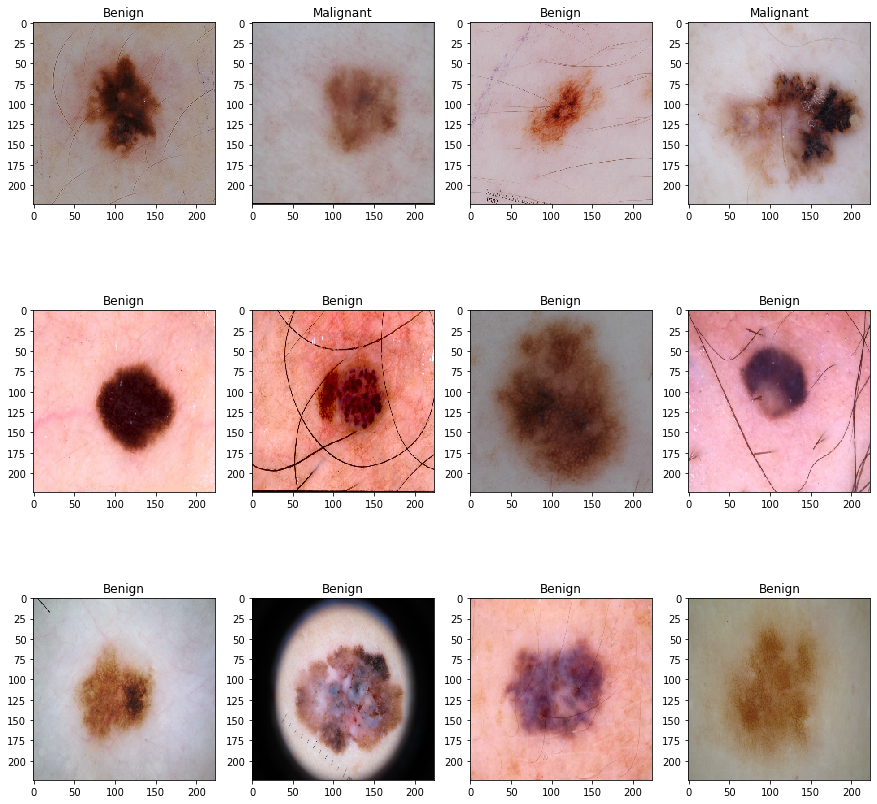

In [6]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [7]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(
        zoom_range=2, 
        rotation_range = 90,
        horizontal_flip=True, 
        vertical_flip=True, 
    )

# Model: ResNet50


In [8]:
def build_model(backbone, lr=5e-4):
    model = Sequential()
    model.add(backbone)
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [9]:
K.clear_session()
gc.collect()

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 23,542,786
Non-trainable params: 57,216
_________________________________________________________________


c:\users\user\pycharmprojects\project_ml\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [10]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [11]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
6/6 [==============================] - 107s 13s/step - loss: 0.8222 - accuracy: 0.5565 - val_loss: 0.8681 - val_accuracy: 0.5413

Epoch 00001: val_accuracy improved from -inf to 0.54128, saving model to weights.best.hdf5


c:\users\user\pycharmprojects\project_ml\venv\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
6/6 [==============================] - 79s 12s/step - loss: 0.7389 - accuracy: 0.6701 - val_loss: 0.6932 - val_accuracy: 0.7431

Epoch 00002: val_accuracy improved from 0.54128 to 0.74312, saving model to weights.best.hdf5
Epoch 3/50
6/6 [==============================] - 79s 12s/step - loss: 0.7295 - accuracy: 0.6396 - val_loss: 0.6063 - val_accuracy: 0.7615

In [12]:
for key in history.history:
    print(key)
print(model.layers)
keras.engine.functional.ModuleWrapper

loss
accuracy
val_loss
val_accuracy
lr
[<keras.engine.functional.Functional object at 0x000002845F4240A0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000002843C7F53A0>, <keras.layers.core.Dropout object at 0x000002843C7E8C10>, <keras.layers.normalization_v2.BatchNormalization object at 0x000002845F706A00>, <keras.layers.core.Dense object at 0x000002845F743EE0>]


keras.engine.functional.ModuleWrapper

In [13]:
model.save('saved.model')

c:\users\user\pycharmprojects\project_ml\venv\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: saved.model\assets


In [14]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<AxesSubplot:>

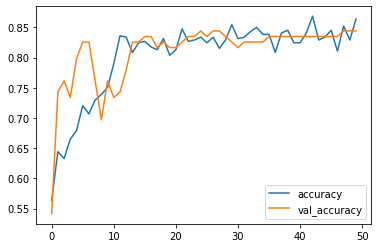

In [15]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [16]:
history_df

loss  accuracy  val_loss  val_accuracy            lr
0   0.825314  0.563510  0.868051      0.541284  1.000000e-04
1   0.747296  0.644342  0.693199      0.743119  1.000000e-04
2   0.723764  0.632794  0.606256      0.761468  1.000000e-04
3   0.716991  0.665127  0.628649      0.733945  1.000000e-04
4   0.697128  0.678984  0.568741      0.798165  1.000000e-04
5   0.657653  0.720554  0.578566      0.825688  1.000000e-04
6   0.648775  0.706697  0.458358      0.825688  1.000000e-04
7   0.644078  0.729792  0.560274      0.761468  1.000000e-04
8   0.602858  0.739030  0.955163      0.697248  1.000000e-04
9   0.566809  0.750577  0.860347      0.761468  1.000000e-04
10  0.544497  0.789838  0.831844      0.733945  1.000000e-04
11  0.476148  0.836028  0.877051      0.743119  2.000000e-05
12  0.504506  0.833718  0.910373      0.779817  2.000000e-05
13  0.550324  0.808314  0.870911      0.825688  2.000000e-05
14  0.457524  0.824480  0.704739      0.825688  2.000000e-05
15  0.504087  0.826790  0.578268      0.834862  2.000000e-05
16  0.454360  0.817552  0.507240      0.834862  2.000000e-05
17  0.540256  0.812933  0.442219      0.816514  2.000000e-05
18  0.448096  0.831409  0.418275      0.825688  2.000000e-05
19  0.455784  0.803695  0.427924      0.816514  2.000000e-05
20  0.467681  0.812933  0.456282      0.816514  2.000000e-05
21  0.411518  0.847575  0.449028      0.825688  4.000000e-06
22  0.471439  0.826790  0.432133      0.834862  4.000000e-06
23  0.458395  0.829099  0.419304      0.834862  4.000000e-06
24  0.430808  0.833718  0.407314      0.844037  4.000000e-06
25  0.448009  0.824480  0.404732      0.834862  4.000000e-06
26  0.430885  0.833718  0.404010      0.844037  4.000000e-06
27  0.449949  0.815242  0.403350      0.844037  4.000000e-06
28  0.424022  0.829099  0.406961      0.834862  4.000000e-06
29  0.388447  0.854503  0.408607      0.825688  4.000000e-06
30  0.422425  0.831409  0.409849      0.816514  8.000000e-07
31  0.442204  0.833718  0.409471      0.825688  8.000000e-07
32  0.408272  0.842956  0.409358      0.825688  8.000000e-07
33  0.398628  0.849885  0.409690      0.825688  8.000000e-07
34  0.432138  0.838337  0.409070      0.825688  8.000000e-07
35  0.392887  0.838337  0.409110      0.834862  1.600000e-07
36  0.492877  0.808314  0.409271      0.834862  1.600000e-07
37  0.443036  0.840647  0.408248      0.834862  1.600000e-07
38  0.419435  0.845266  0.407480      0.834862  1.600000e-07
39  0.440338  0.824480  0.407458      0.834862  1.600000e-07
40  0.440865  0.824480  0.409063      0.834862  1.000000e-07
41  0.421833  0.840647  0.409364      0.834862  1.000000e-07
42  0.359598  0.868360  0.407963      0.834862  1.000000e-07
43  0.456178  0.829099  0.407557      0.834862  1.000000e-07
44  0.432079  0.833718  0.407617      0.834862  1.000000e-07
45  0.433037  0.845266  0.407078      0.834862  1.000000e-07
46  0.435438  0.810624  0.406865      0.834862  1.000000e-07
47  0.409247  0.852194  0.407695      0.844037  1.000000e-07
48  0.457698  0.829099  0.407901      0.844037  1.000000e-07
49  0.387346  0.863741  0.407846      0.844037  1.000000e-07

<AxesSubplot:>

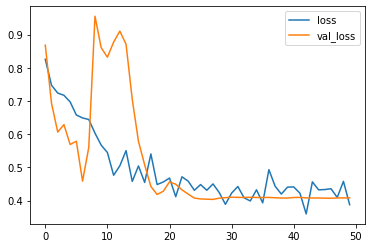

In [17]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [18]:
model.load_weights("weights.best.hdf5")

In [19]:
Y_val_pred = model.predict(x_val)

In [20]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.8440366972477065

In [21]:
Y_pred = model.predict(X_test)

In [22]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]c:\users\user\pycharmprojects\project_ml\venv\lib\site-packages\keras\engine\training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
100%|██████████| 10/10 [01:17<00:00,  7.72s/it]


### Confusion Matrix

Confusion matrix, without normalization
[[97  1]
 [29 23]]


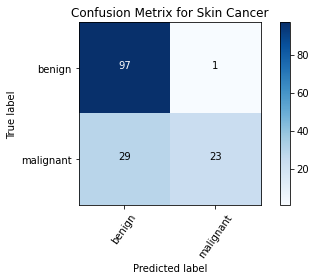

In [23]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[94  4]
 [25 27]]


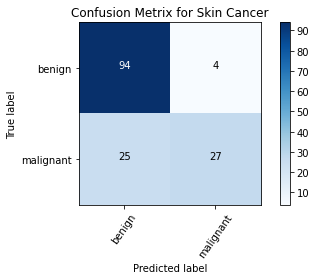

In [24]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

### Classification Report

In [28]:
from sklearn.metrics import classification_report
a = classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

In [29]:
print(a)

              precision    recall  f1-score   support

           0       0.79      0.96      0.87        98
           1       0.87      0.52      0.65        52

    accuracy                           0.81       150
   macro avg       0.83      0.74      0.76       150
weighted avg       0.82      0.81      0.79       150



### ROC and AUC

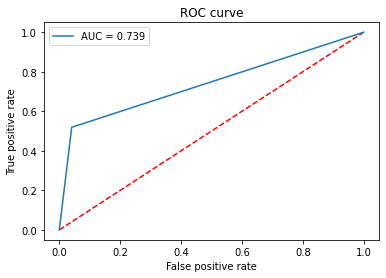

In [26]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()

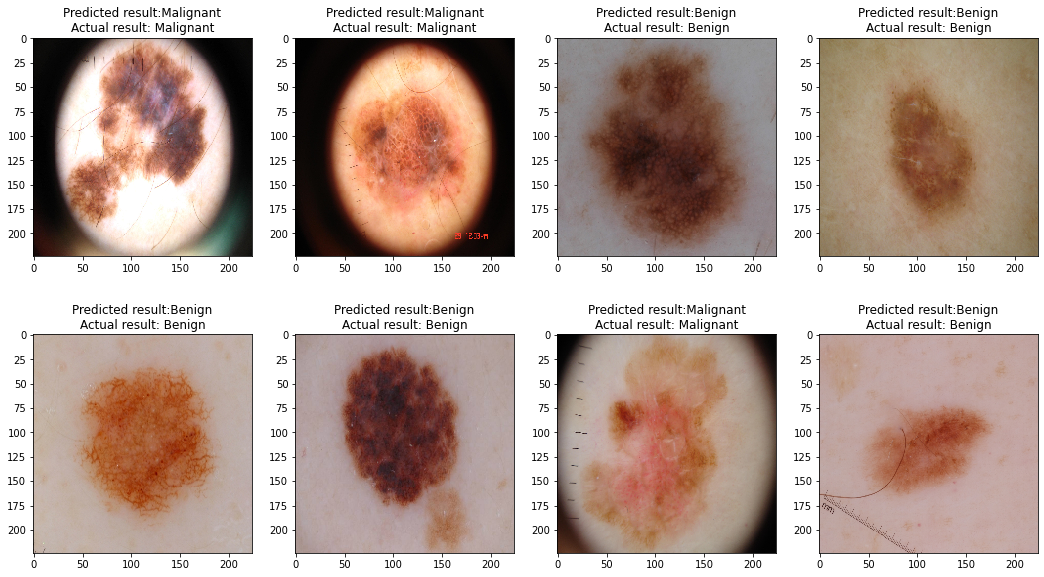

In [27]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()
